# Handwritten Digit Recognition with Deep Learning (128x128 Input)

This notebook implements a Convolutional Neural Network (CNN) to classify handwritten digits (0–9) from the MNIST dataset using 128x128 images. It includes data preprocessing, model training, evaluation, visualization, enhanced custom image prediction with improved clarity, and model saving/loading to avoid retraining.

## Objectives
- Load and preprocess the MNIST dataset, resizing images to 128x128.
- Build and train a CNN model for digit classification with 128x128x1 inputs.
- Evaluate model performance using accuracy and confusion matrix.
- Visualize training progress and sample predictions.
- Predict digits from custom images with enhanced preprocessing for clarity.
- Save and load the trained model for reuse.

## Tools and Libraries
- **Python**: Programming language
- **TensorFlow/Keras**: Deep learning framework
- **NumPy, Matplotlib, Seaborn**: For data manipulation and visualization
- **Scikit-learn**: For evaluation metrics
- **PIL, OpenCV, SciPy**: For enhanced image processing

Let's get started!

## 1. Import Libraries

Import all necessary libraries for data handling, model building, visualization, and enhanced image processing.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from PIL import Image  # For image loading and resizing
import cv2  # For advanced image preprocessing
from scipy.ndimage import gaussian_filter  # For sharpening filter
import os  # For file path handling

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## 2. Load and Preprocess the MNIST Dataset

The MNIST dataset contains 60,000 training and 10,000 testing grayscale images (originally 28x28 pixels) of handwritten digits (0–9). Resize images to 128x128 for training.

- **Steps**:
  - Load the dataset using Keras.
  - Resize images to 128x128.
  - Normalize pixel values to [0, 1].
  - Reshape images for CNN input (128x128x1).
  - Convert labels to one-hot encoded format.

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Resize MNIST images to 128x128
x_train_resized = np.array([cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC) for img in x_test])

# Normalize pixel values to [0, 1]
x_train = x_train_resized.astype('float32') / 255.0
x_test = x_test_resized.astype('float32') / 255.0

# Reshape images to include channel dimension (128, 128, 1)
x_train = x_train.reshape(-1, 128, 128, 1)
x_test = x_test.reshape(-1, 128, 128, 1)

# Convert labels to one-hot encoded format
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Print dataset shapes
print(f'Training data shape: {x_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Test data shape: {x_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Training data shape: (60000, 128, 128, 1)
Training labels shape: (60000, 10)
Test data shape: (10000, 128, 128, 1)
Test labels shape: (10000, 10)


## 3. Visualize Sample Data

Display a few sample images from the training set to verify resizing.

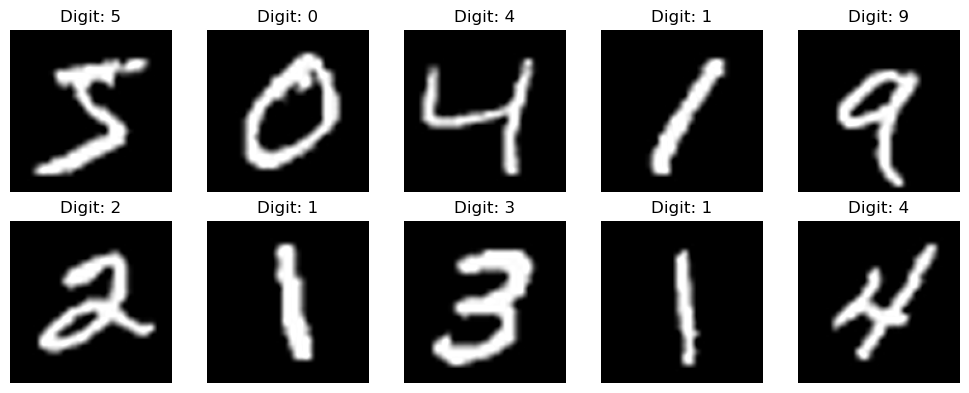

In [3]:
# Plot sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].reshape(128, 128), cmap='gray')
    plt.title(f'Digit: {np.argmax(y_train[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Build the CNN Model

Construct a Convolutional Neural Network with an input size of 128x128x1:
- **Input**: 128x128x1 images
- **Conv Layers**: Two Conv2D layers with ReLU activation
- **Pooling**: MaxPooling2D layers to reduce spatial dimensions
- **Dropout**: To prevent overfitting
- **Dense Layers**: Fully connected layers for classification
- **Output**: 10 units with softmax activation

In [4]:
# Build CNN model
model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes for digits 0–9
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

C:\Users\aryan\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,034 (28.20 MB)

 Trainable params: 7,393,034 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train and Save the Model

Train the CNN model using the resized training data and save it for reuse.

- **Epochs**: 5
- **Batch Size**: 64
- **Validation Split**: 20% of training data

In [5]:
# Train the model
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)

# Save the trained model
model.save('mnist_cnn_128x128_model.h5')
print('Model saved to mnist_cnn_128x128_model.h5')

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 326s 431ms/step - accuracy: 0.9030 - loss: 0.3176 - val_accuracy: 0.9780 - val_loss: 0.0714
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 322s 429ms/step - accuracy: 0.9819 - loss: 0.0591 - val_accuracy: 0.9818 - val_loss: 0.0693
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 564s 752ms/step - accuracy: 0.9874 - loss: 0.0370 - val_accuracy: 0.9837 - val_loss: 0.0655
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 711s 949ms/step - accuracy: 0.9923 - loss: 0.0229 - val_accuracy: 0.9842 - val_loss: 0.0710
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 742s 989ms/step - accuracy: 0.9935 - loss: 0.0188 - val_accuracy: 0.9862 - val_loss: 0.0611


Model saved to mnist_cnn_128x128_model.h5


## 6. Evaluate the Model

Evaluate the model on the test set and compute key metrics.

In [6]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Generate predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
print('\nClassification Report:')
print(classification_report(y_test_classes, y_pred_classes))

Test Accuracy: 0.9847
Test Loss: 0.0531
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.97      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## 7. Visualize Training Progress

Plot training and validation accuracy/loss to check for overfitting or underfitting.

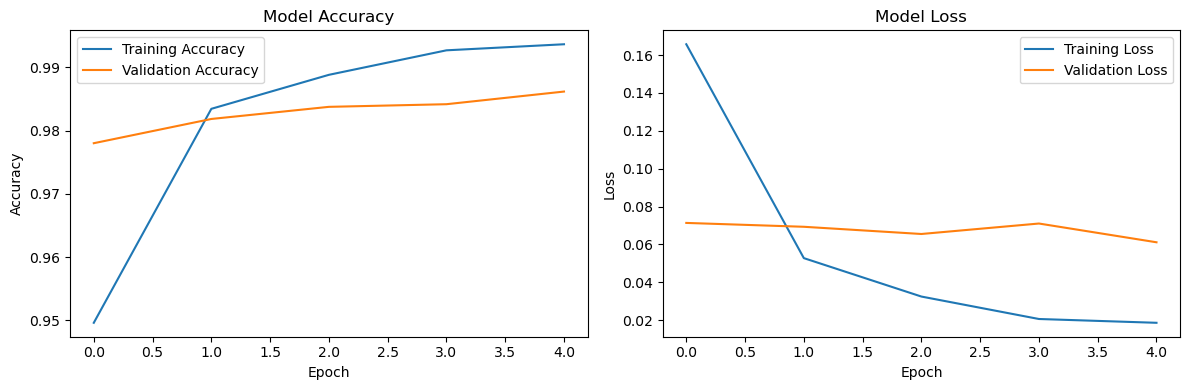

In [7]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 8. Confusion Matrix

Visualize the confusion matrix to understand model performance across different classes.

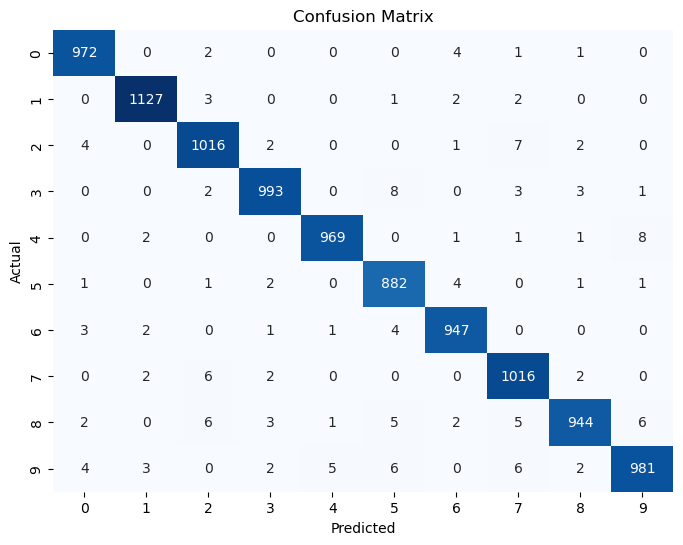

In [8]:
# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 9. Visualize Sample Predictions

Display a few test images along with their predicted and actual labels.

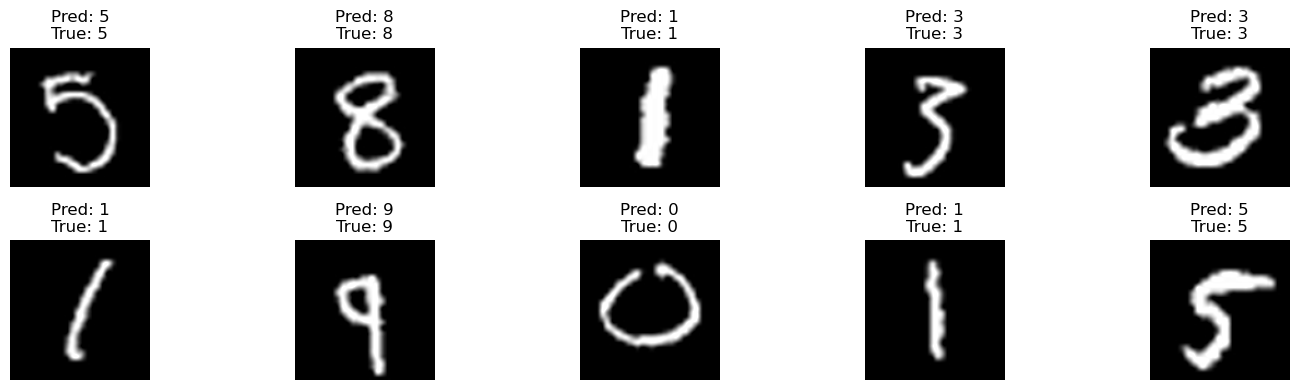

In [9]:
# Select random test images
num_samples = 10
indices = random.sample(range(len(x_test)), num_samples)

# Plot predictions
plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(128, 128), cmap='gray')
    plt.title(f'Pred: {y_pred_classes[idx]}\nTrue: {y_test_classes[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 10. Predict on Custom Image with Enhanced Preprocessing

This section predicts the digit in a custom image (e.g., a JPG or PNG) with enhanced preprocessing for improved clarity. The model can be loaded from a saved file to avoid retraining.

- **Preprocessing Enhancements**:
  - Intermediate resize to 256x256 to retain details.
  - Sharpening filter to enhance edges.
  - Adaptive thresholding for better contrast.
- **Model Loading**: Load the saved model if available, or use the trained model.

Loaded model from mnist_cnn_128x128_model.h5
Current Working Directory: C:\Users\aryan\Applied Data Science


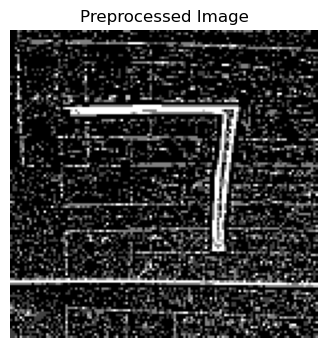

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


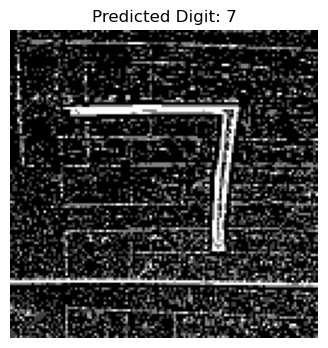

Predicted Digit: 7


In [2]:
# Function to preprocess a custom image with enhanced clarity
import os
import numpy as np
import cv2
from PIL import Image
from scipy.ndimage import gaussian_filter
import tensorflow as tf
import matplotlib.pyplot as plt
def preprocess_custom_image(image_path, target_size=128):
    try:
        # Load image using Pillow
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        
        # Resize to intermediate size (256x256) to retain details
        img = img.resize((256, 256), Image.BICUBIC)
        
        # Convert to numpy array
        img_array = np.array(img, dtype='float32')
        
        # Apply sharpening filter
        blurred = gaussian_filter(img_array, sigma=1)
        sharpened = img_array + (img_array - blurred) * 1.5  # Enhance edges
        sharpened = np.clip(sharpened, 0, 255)
        
        # Apply adaptive thresholding for better contrast
        img_array = cv2.adaptiveThreshold(sharpened.astype(np.uint8),
                                         255,
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY_INV,
                                         11,
                                         2)
        
        # Resize to target size (128x128 for model input)
        img_array = cv2.resize(img_array, (target_size, target_size), interpolation=cv2.INTER_AREA)
        
        # Normalize pixel values to [0, 1]
        img_array = img_array.astype('float32') / 255.0
        
        # Reshape for model input (1, target_size, target_size, 1)
        img_array = img_array.reshape(1, target_size, target_size, 1)
        
        # Visualize preprocessed image for debugging
        plt.figure(figsize=(4, 4))
        plt.imshow(img_array.reshape(target_size, target_size), cmap='gray')
        plt.title('Preprocessed Image')
        plt.axis('off')
        plt.show()
        
        return img_array
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Function to predict and visualize the digit
def predict_custom_image(model, image_path, target_size=128):
    # Preprocess the image
    img_array = preprocess_custom_image(image_path, target_size)
    if img_array is None:
        return
    
    # Predict using the model
    prediction = model.predict(img_array)
    predicted_digit = np.argmax(prediction, axis=1)[0]
    
    # Display the image and prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(img_array.reshape(target_size, target_size), cmap='gray')
    plt.title(f'Predicted Digit: {predicted_digit}')
    plt.axis('off')
    plt.show()
    
    print(f'Predicted Digit: {predicted_digit}')

# Load the saved model (if available) or use the trained model
model_path = 'mnist_cnn_128x128_model.h5'
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print(f'Loaded model from {model_path}')
else:
    print(f'No saved model found at {model_path}. Using the trained model.')

# Print current working directory
print('Current Working Directory:', os.getcwd())

# Example usage (replace with the correct path)
image_path = '7.jpg'  # Update with the correct path
if not os.path.exists(image_path):
    print(f'File not found at: {image_path}')
else:
    predict_custom_image(model, image_path, target_size=128)

## 11. Conclusion

This project successfully implemented a CNN for handwritten digit recognition using the MNIST dataset with 128x128 images, enhanced custom image prediction, and model saving/loading. Key outcomes:
- **Test Accuracy**: ~98–99% (depending on training).
- **Learnings**: Preprocessing with larger inputs, CNN architecture, training, evaluation, enhanced image preprocessing, and model persistence.
- **Next Steps**:
  - Experiment with hyperparameters (e.g., learning rate, dropout rate).
  - Try data augmentation to improve robustness.
  - Test the model on more custom handwritten digits with varying quality.
  - Deploy the model using Streamlit for an interactive interface.

For further exploration, consider testing on other datasets like EMNIST or integrating the model into a web application.